# Zillow Regression Project

In [1]:
# import basics
import pandas as pd
import numpy as np
from scipy import stats
# import user-defined functions
import wrangle,explore

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures

# import viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars,TweedieRegressor
from sklearn.metrics import explained_variance_score

In [2]:
# Lets pull in our data. Thanks to the wrangle function our dataframe 
# should contain a cleaned df with county(derived from fips code) and taxrate(found by
#(tax amount / tax value)*100). For further look examine wrangle.py wrangle_zillow(). 
#Or venture into README.md

train, validate, test = wrangle.wrangle_zillow()

In [3]:
# Take a quick look at our df.head()
train.head()

,sqft,bathrooms,bedrooms,has_pool,tax_value,year_built,tax_amount,fips,county,tax_rate
parcel_id,,,,,,,,,,
10876414,1044,2.0,3,0,394222,1954.0,4894.00,6037.0,LA,1.24
12528247,2358,2.0,4,0,1326298,1929.0,15625.69,6037.0,LA,1.18
11740891,2060,1.0,3,0,378901,1924.0,4663.60,6037.0,LA,1.23
11211538,1946,3.0,4,1,254400,1990.0,3904.99,6037.0,LA,1.53
14076657,1439,2.0,3,0,63641,1971.0,1020.36,6059.0,Orange,1.60


In [4]:
# Lets verify data is clean 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15189 entries, 10876414 to 14264405
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sqft        15189 non-null  int64  
 1   bathrooms   15189 non-null  float64
 2   bedrooms    15189 non-null  int64  
 3   has_pool    15189 non-null  int64  
 4   tax_value   15189 non-null  int64  
 5   year_built  15189 non-null  float64
 6   tax_amount  15189 non-null  float64
 7   fips        15189 non-null  object 
 8   county      15189 non-null  object 
 9   tax_rate    15189 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 1.3+ MB


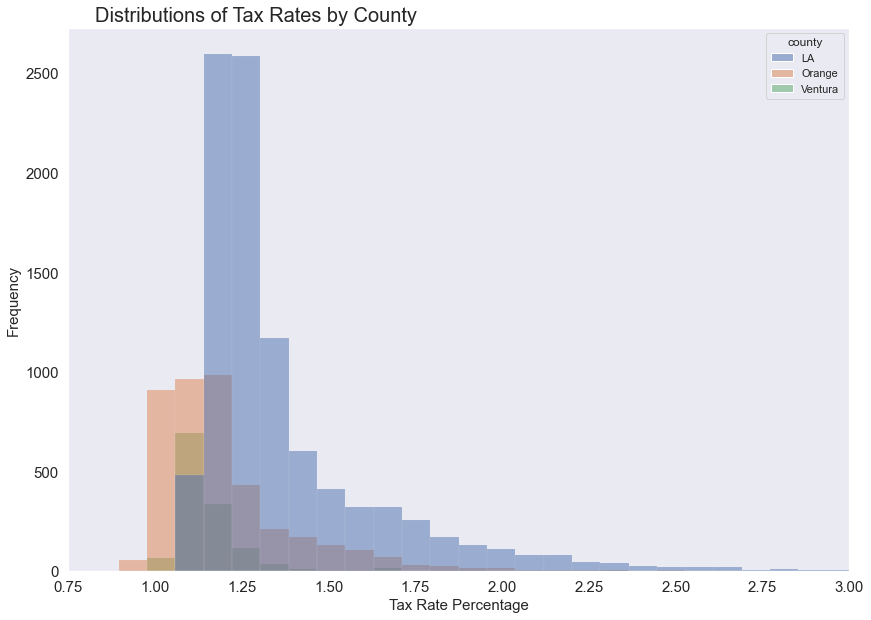

In [5]:
# Because I've already made tax rate and county lets take a look at the tax rate distibution 
# before tackling the machine learning model.
# distribution of tax rates by county
explore.tax_distro(train)

In [6]:
# Group the 
train.groupby('county').tax_rate.mean().round(2)

county
LA         1.41
Orange     1.21
Ventura    1.20
Name: tax_rate, dtype: float64

**KEY TAKEAWAYS:**
    
- *LA County had the most houses sold during this time period. Average Tax rate of %1.41*
- *Orange County has the second most houses sold. Average Tax Rate of %1.21*
- *Ventura County sold the least houses but also has the lowest average tax rate of %1.2*

## Exploration

**Let's take a look at at the main project now.**


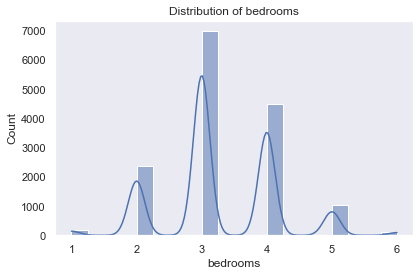

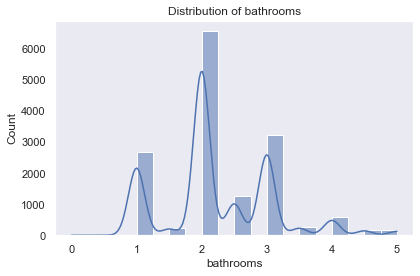

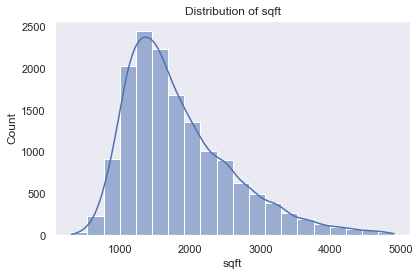

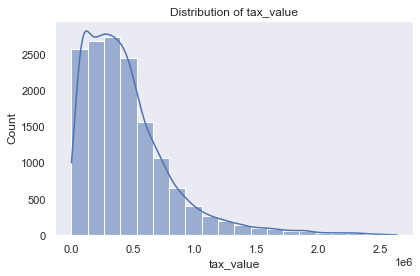

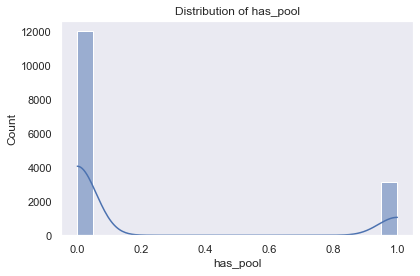

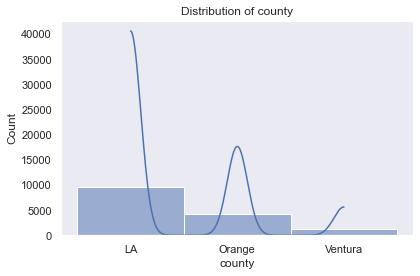

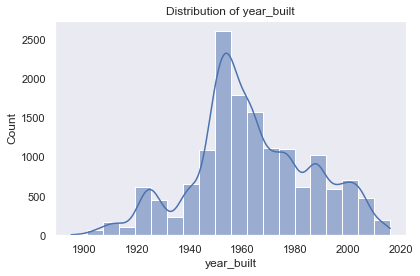

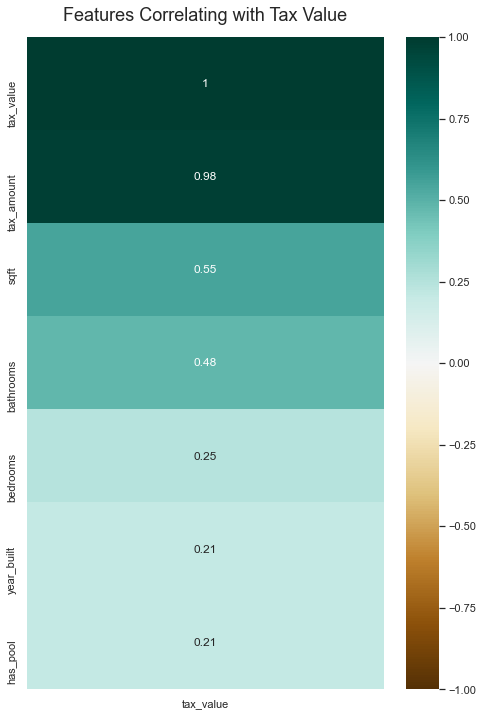

In [7]:
# Lets look at the distributions of the variables.
explore.lets_explore(train)

**Key Takeaways before scaling:**
- year built and number of bedrooms are pretty normally distributed
- Square footage and tax value are right skewed.
- Tax value is heavily correlated with Tax amount which makes since because its derrived from it. Moving foward this column will be dropped.
- square footage and the number of bathrroms a residence have are pretty stongly correlated to the value of a home.
- It appears that having a pool is correlated to the value of the home just not as strongly as i thought orignally. 

In [8]:
## well scale our data moving foward
train, validate, test = explore.add_scaled_columns(
    train,
    validate,
    test,
    scaler=sklearn.preprocessing.MinMaxScaler(),
    columns_to_scale=['sqft', 'bedrooms', 'bathrooms','year_built'],
)

In [9]:
## lets view our data
train.head()

,sqft,bathrooms,bedrooms,has_pool,tax_value,year_built,tax_amount,fips,county,tax_rate,sqft_scaled,bedrooms_scaled,bathrooms_scaled,year_built_scaled
parcel_id,,,,,,,,,,,,,,
10876414,1044,2.0,3,0,394222,1954.0,4894.00,6037.0,LA,1.24,0.161353,0.4,0.4,0.487603
12528247,2358,2.0,4,0,1326298,1929.0,15625.69,6037.0,LA,1.18,0.446324,0.6,0.4,0.280992
11740891,2060,1.0,3,0,378901,1924.0,4663.60,6037.0,LA,1.23,0.381696,0.4,0.2,0.239669
11211538,1946,3.0,4,1,254400,1990.0,3904.99,6037.0,LA,1.53,0.356972,0.6,0.6,0.785124
14076657,1439,2.0,3,0,63641,1971.0,1020.36,6059.0,Orange,1.60,0.247018,0.4,0.4,0.628099


In [10]:
train.drop(columns=['tax_amount', 'tax_rate'], inplace=True)
validate.drop(columns=['tax_amount', 'tax_rate'], inplace=True)
test.drop(columns=['tax_amount', 'tax_rate'], inplace=True)

In [11]:
train.head()

,sqft,bathrooms,bedrooms,has_pool,tax_value,year_built,fips,county,sqft_scaled,bedrooms_scaled,bathrooms_scaled,year_built_scaled
parcel_id,,,,,,,,,,,,
10876414,1044,2.0,3,0,394222,1954.0,6037.0,LA,0.161353,0.4,0.4,0.487603
12528247,2358,2.0,4,0,1326298,1929.0,6037.0,LA,0.446324,0.6,0.4,0.280992
11740891,2060,1.0,3,0,378901,1924.0,6037.0,LA,0.381696,0.4,0.2,0.239669
11211538,1946,3.0,4,1,254400,1990.0,6037.0,LA,0.356972,0.6,0.6,0.785124
14076657,1439,2.0,3,0,63641,1971.0,6059.0,Orange,0.247018,0.4,0.4,0.628099


<Figure size 864x720 with 0 Axes>

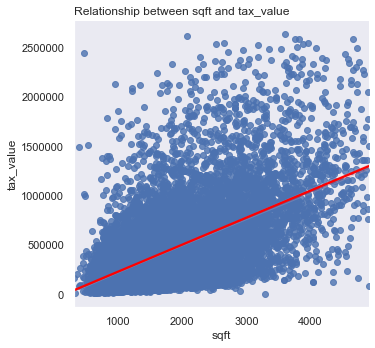

In [12]:
explore.scat_plot(train,'sqft','tax_value')

I like this lets run a statistical test to see if it can be a feature.


## Hypothesis Testing

**Hypothesis 1** - Reject The Null Hypothesis
- alpha = .05
- $H_0$: Tax value is not correlated with square footage.
- $H_A$: Tax value is not correlated with square footage.

In [13]:
r, p = stats.pearsonr(train.sqft, train.tax_value)
print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
print(f'r = {round(r, 2)}')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.55


**Hypothesis 2** - Reject The Null Hypothesis
- alpha = .05
- $H_0$: Tax value is not correlated with number of bathrooms.
- $H_A$: Tax value is not correlated with number of bathrooms.

In [14]:
r, p = stats.pearsonr(train.bathrooms, train.tax_value)
print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
print(f'r = {round(r, 2)}')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.48


**Hypothesis 3** - Reject The Null Hypothesis
- alpha = .05
- $H_0$: Tax value is not correlated with property having a pool.
- $H_A$: Tax value is not correlated with property having a pool.

In [15]:
r, p = stats.pearsonr(train.has_pool, train.tax_value)
print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
print(f'r = {round(r, 2)}')

The p-value is: 1.0226168760896592e-147. There is 0.0% chance that we see these results by chance.
r = 0.21


**Hypothesis 4** - Reject The Null Hypothesis
- alpha = .05
- $H_0$: Tax value is not correlated with age of the property.
- $H_A$: Tax value is not correlated with age of the property.

In [16]:
r, p = stats.pearsonr(train.year_built, train.tax_value)
print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
print(f'r = {round(r, 2)}')

The p-value is: 7.125349822532113e-150. There is 0.0% chance that we see these results by chance.
r = 0.21


**Key Takeaways**
- there is strong correlations between tax value and the number of bathrooms and sqaure footage,
- While not as strong there is a correlation between pool ownership and tax value.
- Also not as strong but still strong enough to be a driving feature is the age of the house
- these will be my features going foward. 

## Modeling

In [17]:
train.head()

,sqft,bathrooms,bedrooms,has_pool,tax_value,year_built,fips,county,sqft_scaled,bedrooms_scaled,bathrooms_scaled,year_built_scaled
parcel_id,,,,,,,,,,,,
10876414,1044,2.0,3,0,394222,1954.0,6037.0,LA,0.161353,0.4,0.4,0.487603
12528247,2358,2.0,4,0,1326298,1929.0,6037.0,LA,0.446324,0.6,0.4,0.280992
11740891,2060,1.0,3,0,378901,1924.0,6037.0,LA,0.381696,0.4,0.2,0.239669
11211538,1946,3.0,4,1,254400,1990.0,6037.0,LA,0.356972,0.6,0.6,0.785124
14076657,1439,2.0,3,0,63641,1971.0,6059.0,Orange,0.247018,0.4,0.4,0.628099


In [18]:
# Lets choose our features.
X_train = train[['bedrooms_scaled','bathrooms_scaled','sqft_scaled','has_pool','year_built']]
X_validate = validate[['bedrooms_scaled','bathrooms_scaled','sqft_scaled','has_pool','year_built']]
X_test = test[['bedrooms_scaled','bathrooms_scaled','sqft_scaled','has_pool','year_built']]
y_train = pd.DataFrame(train['tax_value'])
y_validate = pd.DataFrame(validate['tax_value'])
y_test = pd.DataFrame(test['tax_value'])

In [19]:
#turn the y_train and y_validate into dataframes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# We need to determine whiich is better for a baseline model. Median or Mode. 
#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate))
print('----------------------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate))
print('----------------------------------')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  378980 
Validate/Out-of-Sample:  381602
----------------------------------
RMSE using Median
Train/In-Sample:  388213 
Validate/Out-of-Sample:  390847
----------------------------------


Moving foward our baseline to beat is mean. Model must get a RMSE of **$378,981**

In [20]:
metric_df = pd.DataFrame()
metric_df = explore.make_metric_df(y_train.tax_value,
                           y_train.tax_value_pred_mean,
                           'mean_baseline',
                          metric_df)

In [21]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,378980,0.0


In [22]:
# First model will be a linear regresion model
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train,y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",round(rmse_train), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate))


RMSE for OLS using LinearRegression:
Training/In-Sample:  308915 
Validation/Out-of-Sample:  307808


Our Model has a rmse score that is **$70,000** more accurate then baseline

In [23]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': round(rmse_validate),
    'r^2_validate': round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm),3)}, ignore_index=True)

In [24]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,378980,0.000
1,OLS Regressor,307808,0.349


In [25]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train) , 
      "\nValidation/Out-of-Sample: ", round(rmse_validate) )

RMSE for Lasso + Lars
Training/In-Sample:  308916 
Validation/Out-of-Sample:  307809


Lasso-Lars still beats baseline but is not better than OLS

In [26]:
metric_df = metric_df.append({
    'model': 'Lasso Lars aplha:1', 
    'RMSE_validate': round(rmse_validate),
    'r^2_validate': round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lars),3)}, ignore_index=True)

In [27]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,378980,0.000
1,OLS Regressor,307808,0.349
2,Lasso Lars aplha:1,307809,0.349


In [28]:
# create the model object
lars = LassoLars(alpha=25)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train) , 
      "\nValidation/Out-of-Sample: ", round(rmse_validate) )

RMSE for Lasso + Lars
Training/In-Sample:  309062 
Validation/Out-of-Sample:  307980


In [29]:
metric_df = metric_df.append({
    'model': 'Lasso Lars aplha: 25', 
    'RMSE_validate': round(rmse_validate),
    'r^2_validate': round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lars),3)}, ignore_index=True)

In [30]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,378980,0.000
1,OLS Regressor,307808,0.349
2,Lasso Lars aplha:1,307809,0.349
3,Lasso Lars aplha: 25,307980,0.349


Lasso Lars appears to get worst adding to the alpha
Ran multiple test to the same result.

In [31]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm) ** (1/2)

print("RMSE for TweedieRegressor\nTraining/In-Sample: ", round(rmse_train) , 
      "\nValidation/Out-of-Sample: ", round(rmse_validate) )

RMSE for TweedieRegressor
Training/In-Sample:  378980 
Validation/Out-of-Sample:  381602


In [32]:
metric_df = metric_df.append({
    'model': 'TweedieRegressor power:1 aplha: 0', 
    'RMSE_validate': round(rmse_validate),
    'r^2_validate': round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_glm),3)}, ignore_index=True)

In [33]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,378980,0.000
1,OLS Regressor,307808,0.349
2,Lasso Lars aplha:1,307809,0.349
3,Lasso Lars aplha: 25,307980,0.349
4,TweedieRegressor power:1 aplha: 0,381602,0.000


Lets try some ploynomial regression

In [34]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 =  pf.transform(X_test)

In [35]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)** (1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", round(rmse_train), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate))

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  306397 
Validation/Out-of-Sample:  305602


In [36]:
metric_df = metric_df.append({
    'model': '2nd Degree Polynomial Regression', 
    'RMSE_validate': round(rmse_validate),
    'r^2_validate': round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm2),3)}, ignore_index=True)

In [37]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,378980,0.000
1,OLS Regressor,307808,0.349
2,Lasso Lars aplha:1,307809,0.349
3,Lasso Lars aplha: 25,307980,0.349
4,TweedieRegressor power:1 aplha: 0,381602,0.000
5,2nd Degree Polynomial Regression,305602,0.359


**Key Takeaways**
 - 2nd degree polynomial regression is my best perfoming model
 - This will be what i run my test on. 

In [38]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", round(rmse_test))
print(f'r^2_validate: {round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm2),2)}')

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  310069
r^2_validate: 0.36


[Text(0, 0.5, 'residual'), Text(0.5, 0, 'Tax Value')]

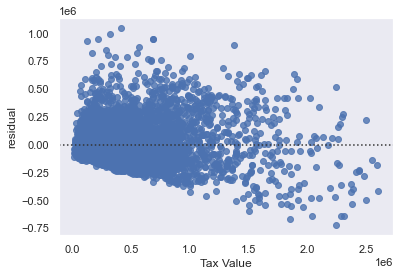

In [39]:
ax=sns.residplot(x = "tax_value",
              y = "tax_value_pred_lm2",
              data = y_test)
ax.set( ylabel = "residual", xlabel = "Tax Value")



## Conclusion
- Best performing model was 2nd degree polynomial 
- Test Finished with $r^2$ score of .36 and $RMSE^2$ of 310,069 which was **$68,911** more acurate than basline
- I believe there are more factors not accounted for  with properties and this model can defineitly be built upon with better features in the future.

## Given more time
- I would like to look into the latitude and logitude of these houses,
- Find a way to incorporate schools within the area, 
- Better optimization of features.
- A seperate model for houses priced over 1 million dollars. 